In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
#from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, text, inspect, func, desc

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\d_ang\AppData\Local\Temp\ipykernel_11116\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [18]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

Text(0, 0.5, 'Precipitation (inches)')

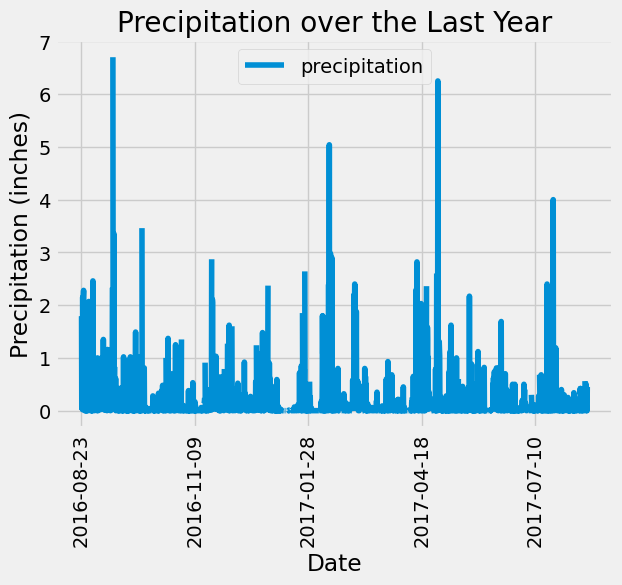

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

precipitation_df = precipitation_df.sort_values('date')


# Sort the dataframe by date
precipitation_df.sort_values(by='date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', rot=90)


plt.title('Precipitation over the Last Year')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')


# Display plot



In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()
summary_statistics 
#this is wrong, need to fix the query at the top

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                                .group_by(Measurement.station)
                                .order_by(desc(func.count(Measurement.station)))
                                .all())
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
(session.query(func.min(Measurement.tobs), 
               func.max(Measurement.tobs), 
               func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all())

[(54.0, 85.0, 71.66378066378067)]

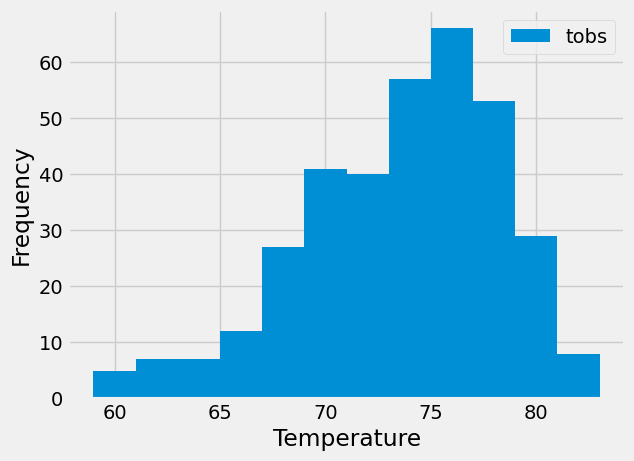

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12_months_data = (session.query(Measurement.tobs)
                       .filter(Measurement.station == most_active_station_id)
                       .filter(Measurement.date >= one_year_ago)
                       .all())
temperatures = [temp[0] for temp in last_12_months_data]


plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [33]:
# Close Session
session.close()